# brain-tumor-Segmentation

### research environment

- hardwear : Nvidia A100

- cuda : version 12.2
- Ubuntu 22.04.1 LTS
- python : 3.8.14
- tensorflow : 2.13.0

### DataSet

- image 
  - mri는 4가지 양식(t1,t1ce,t2,flair)으로 촬영되었고, 4개를 하나의 데이터(RGB Image가 3channel인것과 같음)로 사용함
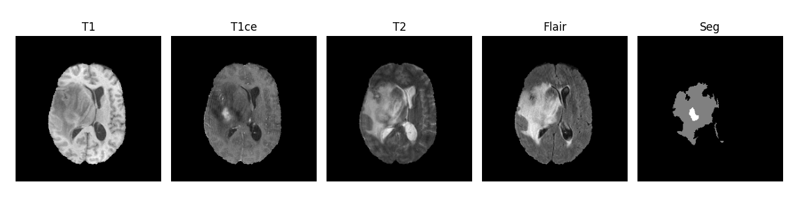

- label
  - 0 : 배경
  - 1 : 전체 종양(Whole tumor)
  - 2 : 핵심 종양(Tumor core)
  - 3 : 조영제 등으로 인해 강조된 종양(enhancing tumor)

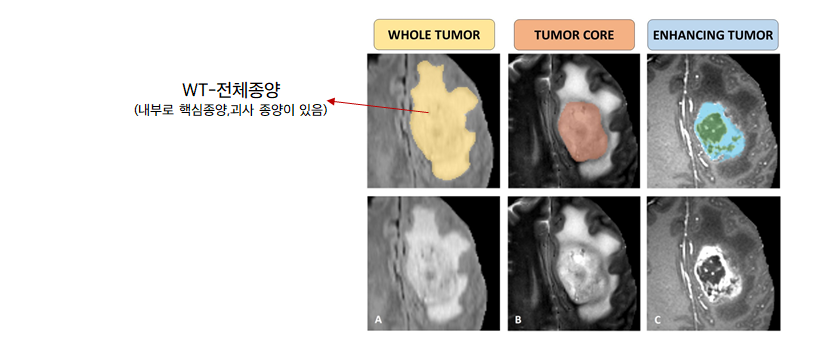

### EDA

train_images : (3906, 240, 240, 4)
train_labels : (3906, 240, 240)
val_images   : (1302, 240, 240, 4)
val_labels   : (1302, 240, 240)
test_images  : (1302, 240, 240, 4)
test_labels  : (1302, 240, 240)


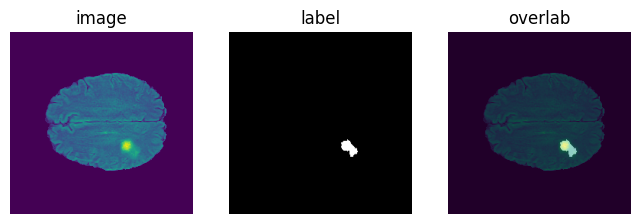

In [1]:
from dataloader import DataProcessor

# 데이터 경로 설정
train_path = '/home/a202192010/2024/Paper_brain_tumor/dataset/basedata/'
val_path = '/home/a202192010/2024/Paper_brain_tumor/dataset/basedata/'
test_path = '/home/a202192010/2024/Paper_brain_tumor/dataset/basedata/'

# DataProcessor 클래스 인스턴스 생성
data_processor = DataProcessor(train_path, val_path, test_path)

# 데이터 로드 및 처리
data_processor.load_and_process_data()

# 데이터셋의 크기 출력
data_processor.print_shapes()

- image, label overlab

In [2]:
train_images = data_processor.train_images
train_labels = data_processor.train_labels
val_images = data_processor.val_images
val_labels = data_processor.val_labels
test_images = data_processor.test_images
test_labels = data_processor.test_labels

- 이런식으로 랜덤하게 5장 더 확인해 본다

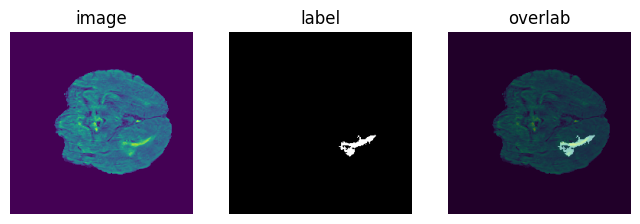

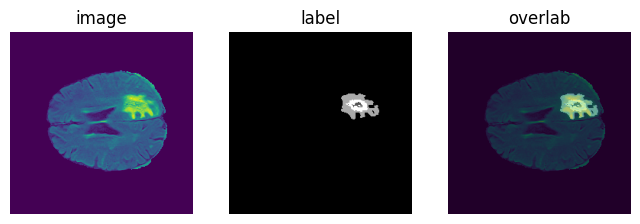

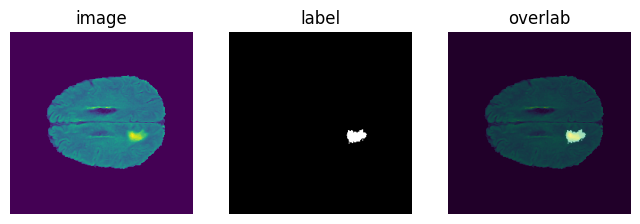

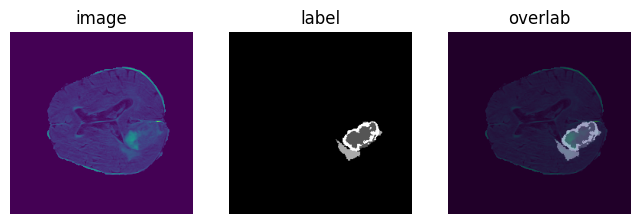

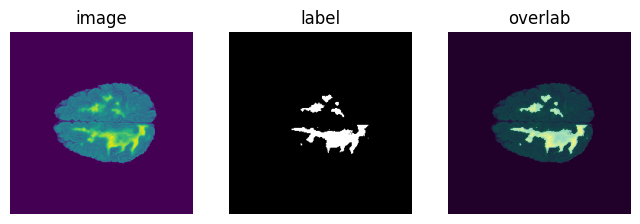

In [35]:
import random

for _ in range(5):
    random_index = random.randint(0, 1000)
    data_processor.visualize_image(num=random_index)

- 각각히 뇌모양도 종양의 모양과 크기도다르다는 것을 알수 있다.
- 기준에 따른 전처리가 요구된다.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

combined_labels = np.concatenate((train_labels, val_labels, test_labels), axis=0)
combined_labels.shape

(6510, 240, 240)

In [8]:
# 레이블 별 픽셀 수 계산
label0_pixels = np.sum(combined_labels == 0)
label1_pixels = np.sum(combined_labels == 1)
label2_pixels = np.sum(combined_labels == 2)
label3_pixels = np.sum(combined_labels == 3)

print("Label 0 pixels:", label0_pixels)
print("Label 1 pixels:", label1_pixels)
print("Label 2 pixels:", label2_pixels)
print("Label 3 pixels:", label3_pixels)

Label 0 pixels: 367211293
Label 1 pixels: 1140885
Label 2 pixels: 5163680
Label 3 pixels: 1460142


- 배경이 0번이 매우 많고 핵심종양인 2번이 많다

In [36]:
no_label0_count = 0
no_label1_count = 0
no_label2_count = 0
no_label3_count = 0

# 레이블이 없는 이미지 선택
for label in combined_labels:
    if np.sum(label == 0) == 0:
        no_label0_count += 1
    if np.sum(label == 1) == 0:
        no_label1_count += 1
    if np.sum(label == 2) == 0:
        no_label2_count += 1
    if np.sum(label == 3) == 0:
        no_label3_count += 1

print("Number of images with no label 0 pixels:", no_label0_count)
print("Number of images with no label 1 pixels:", no_label1_count)
print("Number of images with no label 2 pixels:", no_label2_count)
print("Number of images with no label 3 pixels:", no_label3_count)

Number of images with no label 0 pixels: 0
Number of images with no label 1 pixels: 2850
Number of images with no label 2 pixels: 60
Number of images with no label 3 pixels: 2617


- 1번과 3번의 레이블이 없는 이미지들이 다수 존재한다

In [21]:
label0_pixels = []
label1_pixels = []
label2_pixels = []
label3_pixels = []

# 각 레이블에 대한 픽셀 수
for image in combined_labels:
    label0_pixels.append(np.sum(image == 0))
    label1_pixels.append(np.sum(image == 1))
    label2_pixels.append(np.sum(image == 2))
    label3_pixels.append(np.sum(image == 3))

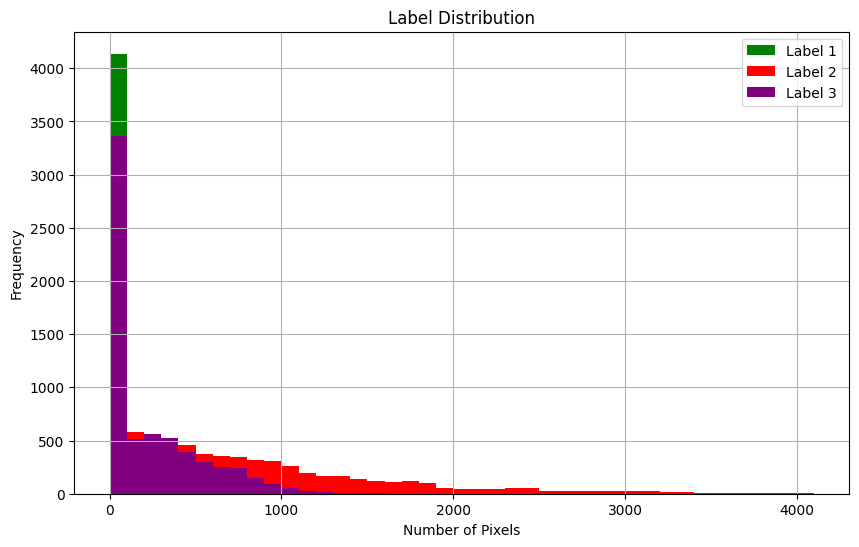

In [27]:
# 히스토그램 그리기
plt.figure(figsize=(10, 6))
#plt.hist(label0_pixels, bins=range(0, max(label0_pixels), 100), alpha=0.5, color='blue', label='Label 0')
plt.hist(label1_pixels, bins=range(0, max(label1_pixels), 100), alpha=1, color='green', label='Label 1')
plt.hist(label2_pixels, bins=range(0, max(label2_pixels), 100), alpha=1, color='red', label='Label 2')
plt.hist(label3_pixels, bins=range(0, max(label3_pixels), 100), alpha=1, color='purple', label='Label 3') 
# 알파를 조정하여 겹치는 값을 확인
 
plt.title('Label Distribution')
plt.xlabel('Number of Pixels')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

- 2번 레이블은 1000개 이상의 픽셀을 가진 이미지가 많고 200~300개 픽셀 범위는 1,3 에 비해 매우 적다

- 핵심종양의 크기가 크다는 것을 알 수가 있다

### Base model

In [38]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2, os, glob

np.set_printoptions(threshold=np.inf) # NumPy 설정
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # CUDA 가시성 설정 (GPU 사용시 필요)

# GPU 메모리 구성 설정 (GPU 사용시 필요)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # TensorFlow 2.x에서는 set_memory_growth 대신에 메모리 할당 옵션을 설정하는 코드
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [37]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels, num_classes=4)
val_labels = to_categorical(val_labels, num_classes=4)

2024-05-25 15:11:24.331748: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-25 15:11:24.437853: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 15:11:26.176339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


- Loss Functions

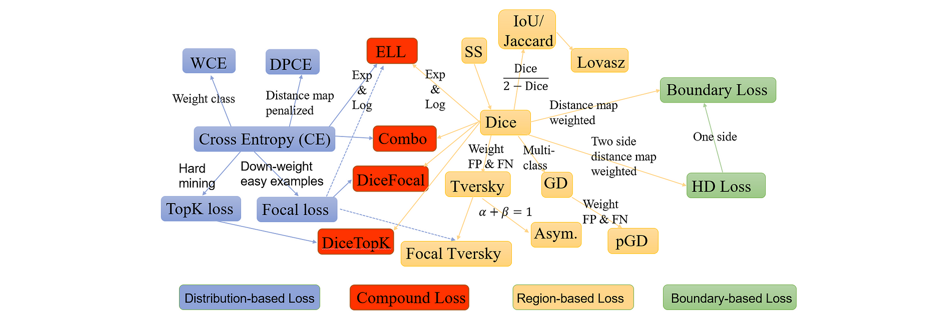

In [44]:
## loss function

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

# Binary Crossentropy Dice Loss
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [45]:
## Measurement

def sensitivity(cm, n):  # recall, True Positive Rate
    sen = []
    for i in range(n):
        tp = cm[i][i]
        sen1 = round((tp / np.sum(cm[i, :])), 4)
        sen.append(sen1)
    return sen

class_name = ["0", "1", "2", "3"]

def specificity(cm, n): # True_negative_rate
    TNR = []
    all = np.sum(cm)
    for i in range(n):
        TP = cm[i][i]
        FP = np.sum(cm[:,i]) - TP
        FN = np.sum(cm[i,:]) - TP
        TN = all - FP - FN - TP
        tnr = round((TN/(FP+TN)),4)
        TNR.append(tnr)
    return TNR

def F1_score(cm, n):
    f1_score = []

    for i in range(n):
        TP = cm[i][i]
        FP = np.sum(cm[:,i]) - TP
        FN = np.sum(cm[i,:]) - TP
        f1score = round(((2*TP) / (2*TP+FP+FN)),4)
        f1_score.append(f1score)
    return f1_score

def precision(cm, n): # Ppv
    positive_predictive_value = []
    
    for i in range(n):
        TP = cm[i][i]
        TP_FP = np.sum(cm[:,i])
        ppv = round((TP/TP_FP), 4)
        positive_predictive_value.append(ppv)
    return positive_predictive_value

In [46]:
## result vvisualization

def visual_num(n) :
    num =n
    test_image = test_images[num]
    test_label = test_labels[num]
    prediction = model.predict(np.expand_dims(test_image, axis=0))[0]
    prediction = np.argmax(prediction, axis=-1)
# 예측 결과 시각화
    plt.figure(figsize=(9,5))
    plt.subplot(241) ;  plt.imshow(test_image[:,:,0], cmap='gray') ; plt.title('T1');plt.axis('off')
    plt.subplot(242) ;  plt.imshow(test_image[:,:,1], cmap='gray') ; plt.title('T1ce'); plt.axis('off')
    plt.subplot(243) ;  plt.imshow(test_image[:,:,2], cmap='gray') ; plt.title('T2'); plt.axis('off')
    plt.subplot(244) ;  plt.imshow(test_image[:,:,3], cmap='gray') ; plt.title('flair'); plt.axis('off')
    t1 = np.where(test_label == 0, 1,0).astype('uint8')
    t2 = np.where(test_label == 1, 1,0).astype('uint8')
    t3 = np.where(test_label == 2, 1,0).astype('uint8')
    t4 = np.where(test_label == 3, 1,0).astype('uint8')
    plt.subplot(245); plt.imshow(test_label, cmap='gray'); plt.title('Ground Truth');plt.axis('off')
    plt.subplot(2,4,6) ; plt.imshow(prediction, cmap='gray'); plt.title('Predicted');plt.axis('off')
    plt.subplot(2,4,7) ; plt.imshow(abs(test_label-prediction), cmap='gray'); plt.title('GT - pred');plt.axis('off')
    plt.subplot(2,4,8) ; plt.imshow(test_image[:,:,3], cmap='gray'); plt.title('flair overlab');plt.axis('off')
    plt.subplot(2,4,8) ; plt.imshow(abs(test_label-prediction), cmap='jet',alpha=0.5);plt.axis('off')
    t = test_label.flatten()
    p = prediction.flatten()
    matches = t == p
    num_mismatches = len(matches) - np.count_nonzero(matches)
    mismatch_indices = np.where(matches == False)[0]
    print("mismatched labels:", num_mismatches)
    plt.tight_layout();plt.show()

### Model

In [47]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model

input_shape = (240, 240, 4)
inputs = Input(shape=input_shape)

# Encoder
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2) 
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

# Middle
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4) 
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

# Decoder
up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=-1)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)


up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=-1)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=-1)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=-1)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

# Output
outputs = Conv2D(4, (1, 1), activation='softmax')(conv9)
model = Model(inputs=inputs, outputs=outputs)
model.summary()


2024-05-25 15:15:27.738016: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38357 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:af:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 240, 240, 64)         2368      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 240, 240, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 120, 120, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

### Model fit

In [48]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy'])

# 커널이 죽는다면 batch_size를 줄이면 됨
history= model.fit(train_images, train_labels, epochs=100, batch_size=32, validation_data=(val_images, val_labels))

Epoch 1/100


2024-05-25 15:16:15.295416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-05-25 15:16:15.494800: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-25 15:16:19.335868: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x9636470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-25 15:16:19.335969: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-05-25 15:16:19.345470: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-25 15:16:19.496385: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-25 15:16:19.608607: I ./tensorflow/compiler/jit/device_compiler.h:

123/123 [==============================] - 72s 332ms/step - loss: 0.1587 - accuracy: 0.9724 - val_loss: 0.0511 - val_accuracy: 0.9813
Epoch 2/100
123/123 [==============================] - 26s 208ms/step - loss: 0.0411 - accuracy: 0.9843 - val_loss: 0.0598 - val_accuracy: 0.9791
Epoch 3/100
123/123 [==============================] - 25s 207ms/step - loss: 0.0332 - accuracy: 0.9872 - val_loss: 0.0255 - val_accuracy: 0.9897
Epoch 4/100
123/123 [==============================] - 27s 219ms/step - loss: 0.0238 - accuracy: 0.9905 - val_loss: 0.0241 - val_accuracy: 0.9901
Epoch 5/100
123/123 [==============================] - 26s 212ms/step - loss: 0.0206 - accuracy: 0.9918 - val_loss: 0.0221 - val_accuracy: 0.9911
Epoch 6/100
123/123 [==============================] - 26s 215ms/step - loss: 0.0181 - accuracy: 0.9927 - val_loss: 0.0188 - val_accuracy: 0.9926
Epoch 7/100
123/123 [==============================] - 26s 210ms/step - loss: 0.0176 - accuracy: 0.9929 - val_loss: 0.0154 - val_accurac

Epoch 57/100
123/123 [==============================] - 25s 202ms/step - loss: 0.0045 - accuracy: 0.9981 - val_loss: 0.0072 - val_accuracy: 0.9971
Epoch 58/100
123/123 [==============================] - 26s 208ms/step - loss: 0.0045 - accuracy: 0.9981 - val_loss: 0.0070 - val_accuracy: 0.9971
Epoch 59/100
123/123 [==============================] - 25s 200ms/step - loss: 0.0044 - accuracy: 0.9981 - val_loss: 0.0070 - val_accuracy: 0.9972
Epoch 60/100
123/123 [==============================] - 25s 199ms/step - loss: 0.0043 - accuracy: 0.9982 - val_loss: 0.0071 - val_accuracy: 0.9971
Epoch 61/100
123/123 [==============================] - 25s 202ms/step - loss: 0.0043 - accuracy: 0.9982 - val_loss: 0.0077 - val_accuracy: 0.9969
Epoch 62/100
123/123 [==============================] - 25s 200ms/step - loss: 0.0045 - accuracy: 0.9981 - val_loss: 0.0075 - val_accuracy: 0.9970
Epoch 63/100
123/123 [==============================] - 25s 202ms/step - loss: 0.0043 - accuracy: 0.9982 - val_loss: 0

- 기본적인 Unet 모델을 통하여 성능을 확인
- 옵티마이저는 adam
- 로스함수는 bce_dice_loss(Binary Cross Entropy and Dice Loss)

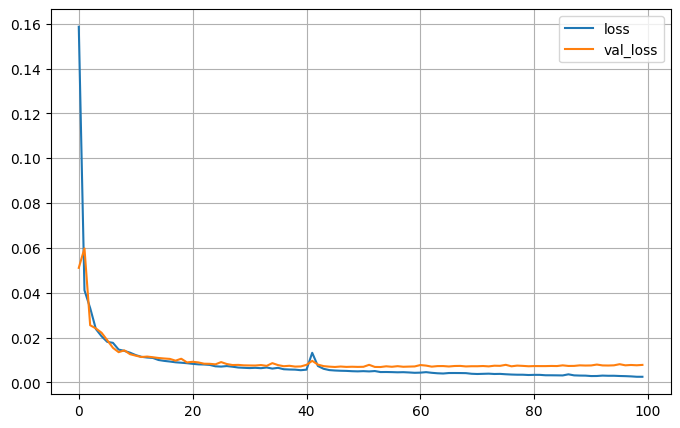

(<matplotlib.legend.Legend at 0x7fc3ada5c070>, None, None)

In [50]:
plot_target = ['loss', 'val_loss']
plt.figure(figsize=(8,5))
for each in plot_target:
    plt.plot(history.history[each], label = each)
plt.legend(), plt.grid(), plt.show()

### test data evaluate

In [ ]:
# ### when you test with h5 weights

# from tensorflow.keras.losses import binary_crossentropy
# import tensorflow as tf

# custom_objects = {'bce_dice_loss': bce_dice_loss}
# model = load_model("croped_4channel_unet_nobridge.h5", custom_objects=custom_objects)

In [51]:
test_label_e = to_categorical(test_labels, num_classes=4)
loss, acc = model.evaluate(test_images, test_label_e, verbose=2)

41/41 - 3s - loss: 0.0078 - accuracy: 0.9972 - 3s/epoch - 67ms/step


In [52]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_images)

y_true = np.argmax(test_label_e, axis=3)
y_pred = np.argmax(y_pred, axis=3)

y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

conf_mat = confusion_matrix(y_true_flat, y_pred_flat)

41/41 [==============================] - 3s 56ms/step


In [53]:
import pandas as pd

Sensitivity = sensitivity(conf_mat, 4)
Specificity = specificity(conf_mat, 4)
f1 = F1_score(conf_mat, 4)
Positive_predictive_value = precision(conf_mat, 4)

data = {'Sensitivity': Sensitivity,
        'Specificity': Specificity,
        'F1 Score': f1,
        'Precision': Positive_predictive_value}

df = pd.DataFrame(data, index=class_name)
df.loc['Col Ave'] = df.mean()

df

,Sensitivity,Specificity,F1 Score,Precision
0,0.999200,0.94180,0.99900,0.9988
1,0.863600,0.99970,0.87860,0.8942
2,0.913800,0.99910,0.92340,0.9332
3,0.887500,0.99960,0.88920,0.8910
Col Ave,0.916025,0.98505,0.92255,0.9293


- 선택한 measure 로는 recall 값을 이용한다.
- 기본 유넷의 경우 0.91 정도가 평균이고
- 여러 시도들이 있었지만 전반적으로 전체종양인 1번 레이블의 recall 을 올리기가 쉽지않다.

### result

1 )
1/1 [==============================] - 1s 819ms/step
mismatched labels: 115


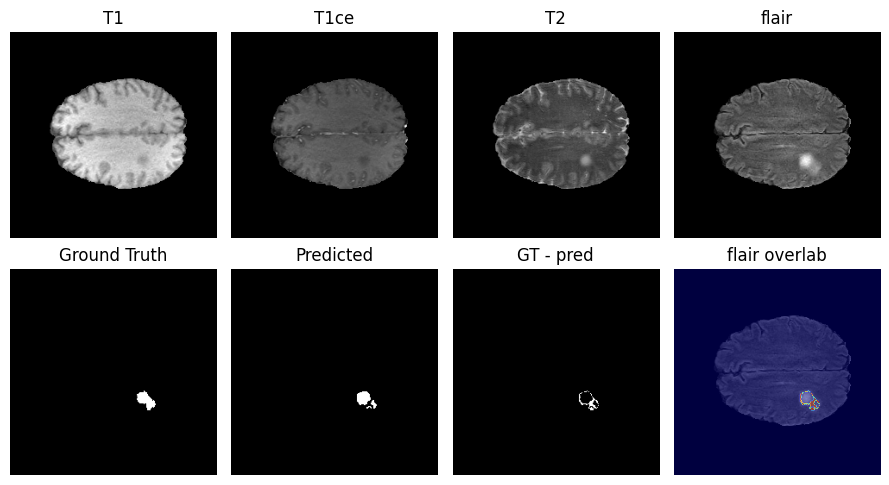

2 )
1/1 [==============================] - 0s 51ms/step
mismatched labels: 91


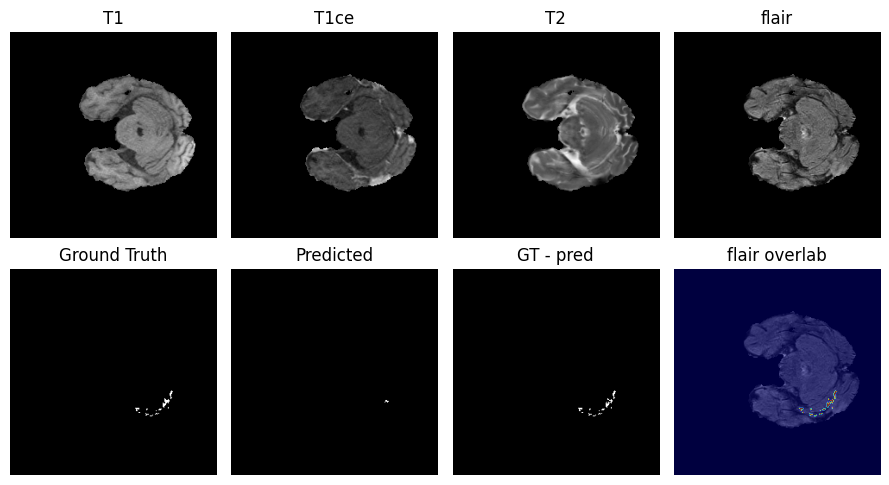

3 )
1/1 [==============================] - 0s 62ms/step
mismatched labels: 188


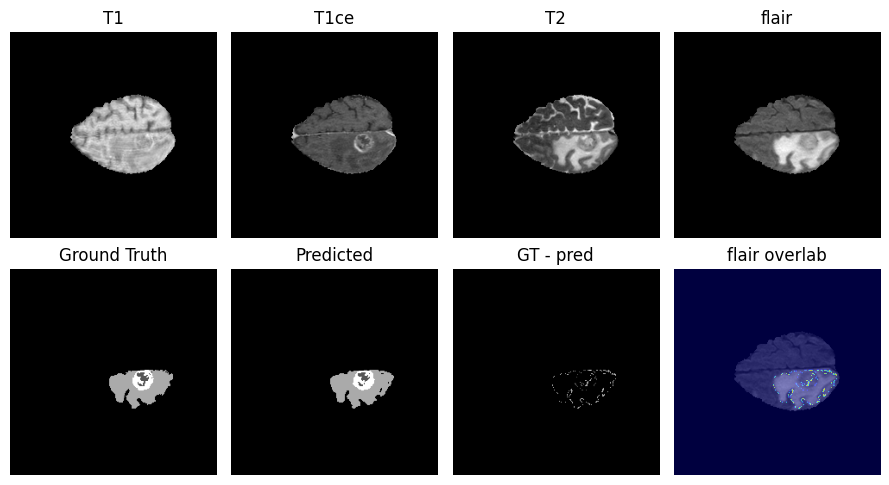

4 )
1/1 [==============================] - 0s 54ms/step
mismatched labels: 125


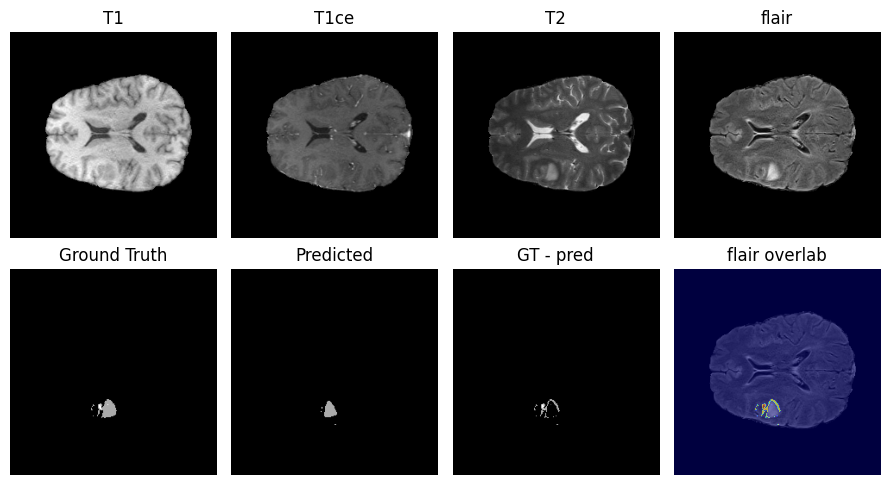

5 )
1/1 [==============================] - 0s 53ms/step
mismatched labels: 314


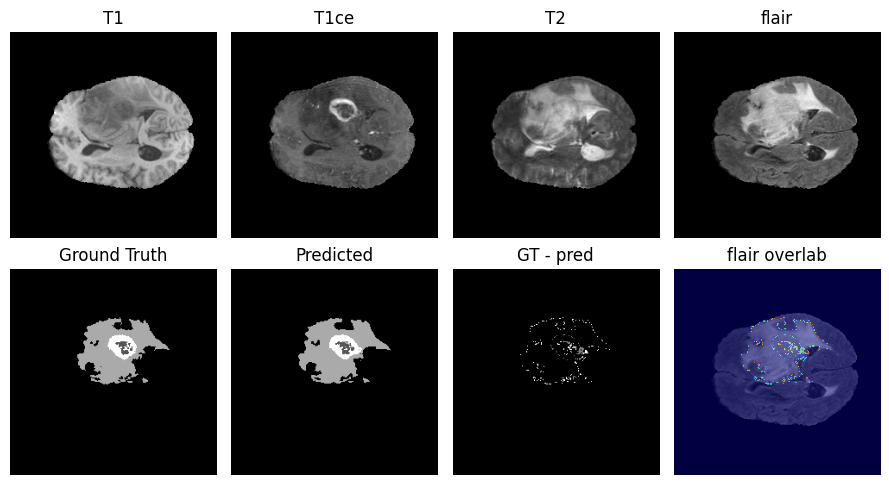

In [54]:
for i in range(5) :
    print(i+1,")")
    visual_num(i)

- 위 5가지 이미지들은 랜덤한 Test 이미지 예측결과이다.
- 공통적으로 뇌종양의 테두리 부분을 인식하지 못하는 문제가 있다
- 이 부분을 모델,로스,전처리 등 다양한 방법을 통해 개선할 것 이다.

In [ ]:
#model.save('../model(1).h5')